In [1]:
from keras.datasets import mnist
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import feature, exposure
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import pickle
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

Phase 1

In [2]:
# Specify the path to your mnist.npz file
file_path = 'mnist.npz'

# Load the dataset
with np.load(file_path) as data:
    x_train = data['x_train']
    y_train = data['y_train']
    x_test = data['x_test']
    y_test = data['y_test']

# Check the shapes of the loaded data
print("Training data shape:", x_train.shape)  # Should output (60000, 28, 28)
print("Training labels shape:", y_train.shape)  # Should output (60000,)
print("Test data shape:", x_test.shape)   # Should output (10000, 28, 28)
print("Test labels shape:", y_test.shape)   # Should output (10000,)


x_combined = np.concatenate((x_train, x_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

print("Combined data shape:", x_combined.shape)  
print("Combined labels shape:", y_combined.shape)

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)
Combined data shape: (70000, 28, 28)
Combined labels shape: (70000,)


In [3]:
def convolution2d(image, kernel):
    # Get the dimensions of the image and kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # Calculate output dimensions
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1
    
    # Create an output array with the calculated dimensions
    output = np.zeros((output_height, output_width))
    
    # Perform convolution operation
    for i in range(output_height):
        for j in range(output_width):
            # Multiply the current section of the image by the kernel and sum it up
            output[i, j] = np.sum(image[i:i+kernel_height, j:j+kernel_width] * kernel)
    
    return output

0 Padding

In [4]:
pad_width = 1

# padded_x_test = np.array([])
padded_x_test = np.empty((10000, 30, 30),  dtype=int)
padded_x_train = np.empty((60000, 30, 30),  dtype=int)


for i in range(10000):
    original_image = x_test[i]
    padded_image = np.pad(original_image, pad_width=pad_width, mode='constant', constant_values=0)
    padded_x_test[i] = padded_image

for i in range(60000):
    original_image = x_train[i]
    padded_image = np.pad(original_image, pad_width=pad_width, mode='constant', constant_values=0)
    padded_x_train[i] = padded_image


Sobel 1

In [78]:
kernel = np.empty((3, 3), dtype=int)

# Correctly assign a 2D array to the first slice of the kernel
kernel = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]])

# padded_x_test = np.array([])
sobel1_x_test = np.empty((10000, 28, 28),  dtype=int)
sobel1_x_train = np.empty((60000, 28, 28),  dtype=int)


for i in range(10000):
    original_image = padded_x_test[i]
    temp = convolution2d(original_image, kernel)
    sobel1_x_test[i] = temp

for i in range(60000):
    original_image = padded_x_train[i]
    temp = convolution2d(original_image, kernel)
    sobel1_x_train[i] = temp


Sobel2


In [80]:
kernel = np.empty((3, 3), dtype=int)

# Correctly assign a 2D array to the first slice of the kernel
kernel = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]])

# padded_x_test = np.array([])
sobel2_x_test = np.empty((10000, 28, 28),  dtype=int)
sobel2_x_train = np.empty((60000, 28, 28),  dtype=int)


for i in range(10000):
    original_image = padded_x_test[i]
    temp = convolution2d(original_image, kernel)
    sobel2_x_test[i] = temp

for i in range(60000):
    original_image = padded_x_train[i]
    temp = convolution2d(original_image, kernel)
    sobel2_x_train[i] = temp

Sobel final

In [100]:
x = sobel1_x_test
y = sobel2_x_test
sobel_x_test = np.sqrt(x**2 + y**2)

x = sobel1_x_train
y = sobel2_x_train
sobel_x_train = np.sqrt(x**2 + y**2)

print(sobel_x_train.shape)
print(sobel_x_test.shape)
# print(sobel_x_train[50000])

(60000, 28, 28)
(10000, 28, 28)


Sobel normalization

In [102]:
result_min = sobel_x_test.min()
result_max = sobel_x_test.max()
if result_max - result_min > 0:
    normalized_result = (sobel_x_test - result_min) / (result_max - result_min)
else:
    normalized_result = np.zeros_like(sobel_x_test)  # All values are the same

# Step 2: Scale to [0, 255]
sobel_x_test_final = normalized_result * 255

# Step 3: Convert to int
sobel_x_test_final = sobel_x_test_final.astype(int)
print("Shape of the scaled result:", sobel_x_test_final.shape)
print("Min value in scaled result:", sobel_x_test_final.min())
print("Max value in scaled result:", sobel_x_test_final.max())
# print(scaled_result[400])

Shape of the scaled result: (10000, 28, 28)
Min value in scaled result: 0
Max value in scaled result: 255


In [109]:
result_min = sobel_x_train.min()
result_max = sobel_x_train.max()
if result_max - result_min > 0:
    normalized_result = (sobel_x_train - result_min) / (result_max - result_min)
else:
    normalized_result = np.zeros_like(sobel_x_train)  # All values are the same

# Step 2: Scale to [0, 255]
sobel_x_train_final = normalized_result * 255

# Step 3: Convert to int
sobel_x_train_final = sobel_x_train_final.astype(int)
print("Shape of the scaled result:", sobel_x_train_final.shape)
print("Min value in scaled result:", sobel_x_train_final.min())
print("Max value in scaled result:", sobel_x_train_final.max())


Shape of the scaled result: (60000, 28, 28)
Min value in scaled result: 0
Max value in scaled result: 255


Save Sobel

In [ ]:

np.save('sobel_x_train_final.npy', sobel_x_train_final)
np.save('sobel_x_test_final.npy', sobel_x_test_final)



Load Sobel


In [5]:
sobel_x_train_final = np.load('sobel_x_train_final.npy')

sobel_x_test_final = np.load('sobel_x_test_final.npy')

HOG

In [59]:
orientations = 9
pixels_per_cell = (8,8)  # Set to (4, 4) for better feature extraction on small images
cells_per_block = (2, 2)   # Set to (2, 2) for normalization


HOG_test = np.empty((10000, 28, 28))
HOG_test_f = np.empty((10000, 144))

HOG_train = np.empty((60000, 28, 28))
HOG_train_f = np.empty((60000, 144))

combined_features_list = []


for i in range(10000):
    original_image = x_test[i]
    hog_features, hog_image = feature.hog(original_image, orientations=orientations,
                                       pixels_per_cell=pixels_per_cell,
                                       cells_per_block=cells_per_block,
                                       visualize=True, feature_vector=True)
    HOG_test[i] = hog_image
    HOG_test_f[i] = hog_features
    combined_features = np.concatenate((sobel_x_test_final[i].flatten(), hog_features))
    combined_features_list.append(combined_features)
    

HOG_sobel_test = np.array(combined_features_list)

combined_features_list = []

for i in range(60000):
    original_image = x_train[i]
    hog_features, hog_image = feature.hog(original_image, orientations=orientations,
                                       pixels_per_cell=pixels_per_cell,
                                       cells_per_block=cells_per_block,
                                       visualize=True, feature_vector=True)
    HOG_train[i] = hog_image
    HOG_train_f[i] = hog_features
    combined_features = np.concatenate((sobel_x_train_final[i].flatten(), hog_features))
    combined_features_list.append(combined_features)
    

HOG_sobel_train = np.array(combined_features_list)
print(HOG_sobel_test.shape)
print(HOG_sobel_train.shape)

(10000, 928)
(60000, 928)


save HOG

In [61]:
np.save('HOG_train.npy', HOG_train)
np.save('HOG_train_f.npy', HOG_train_f)

np.save('HOG_test.npy', HOG_test)
np.save('HOG_test_f.npy', HOG_test_f)

np.save('HOG_sobel_test.npy', HOG_sobel_test)
np.save('HOG_sobel_train.npy', HOG_sobel_train)

Load HOG

In [6]:
HOG_test = np.load('HOG_test.npy')
HOG_test_f = np.load('HOG_test_f.npy')

HOG_train = np.load('HOG_train.npy')
HOG_train_f = np.load('HOG_train_f.npy')

HOG_sobel_test = np.load('HOG_sobel_test.npy')
HOG_sobel_train = np.load('HOG_sobel_train.npy')

Laplacian filter (Optional filter)

In [214]:
kernel = np.empty((3, 3), dtype=int)

# Correctly assign a 2D array to the first slice of the kernel
kernel = np.array([[0, 1, 0],
                   [1, -4, 1],
                   [0, 1, 0]])

# padded_x_test = np.array([])
Laplacian_test = np.empty((10000, 28, 28),  dtype=int)
Laplacian_train = np.empty((60000, 28, 28),  dtype=int)


for i in range(10000):
    original_image = padded_x_test[i]
    temp = convolution2d(original_image, kernel)
    Laplacian_test[i] = temp

for i in range(60000):
    original_image = padded_x_train[i]
    temp = convolution2d(original_image, kernel)
    Laplacian_train[i] = temp

Save Laplacian

In [218]:
np.save('Laplacian_test.npy', Laplacian_test)
np.save('Laplacian_train.npy', Laplacian_train)

Load Laplacian

In [7]:
Laplacian_test = np.load('Laplacian_test.npy')
Laplacian_train = np.load('Laplacian_train.npy')

In [10]:
Laplacian_train_reshaped = Laplacian_train.reshape(60000, 28 * 28)
Laplacian_test_reshaped = Laplacian_test.reshape(10000, 28 * 28)
print(Laplacian_test_reshaped.shape)
print(Laplacian_train_reshaped.shape)

(10000, 784)
(60000, 784)


In [14]:
HOG_Laplacian_test = np.concatenate((Laplacian_test_reshaped, HOG_test_f), axis=1)
HOG_Laplacian_train = np.concatenate((Laplacian_train_reshaped, HOG_train_f), axis=1)

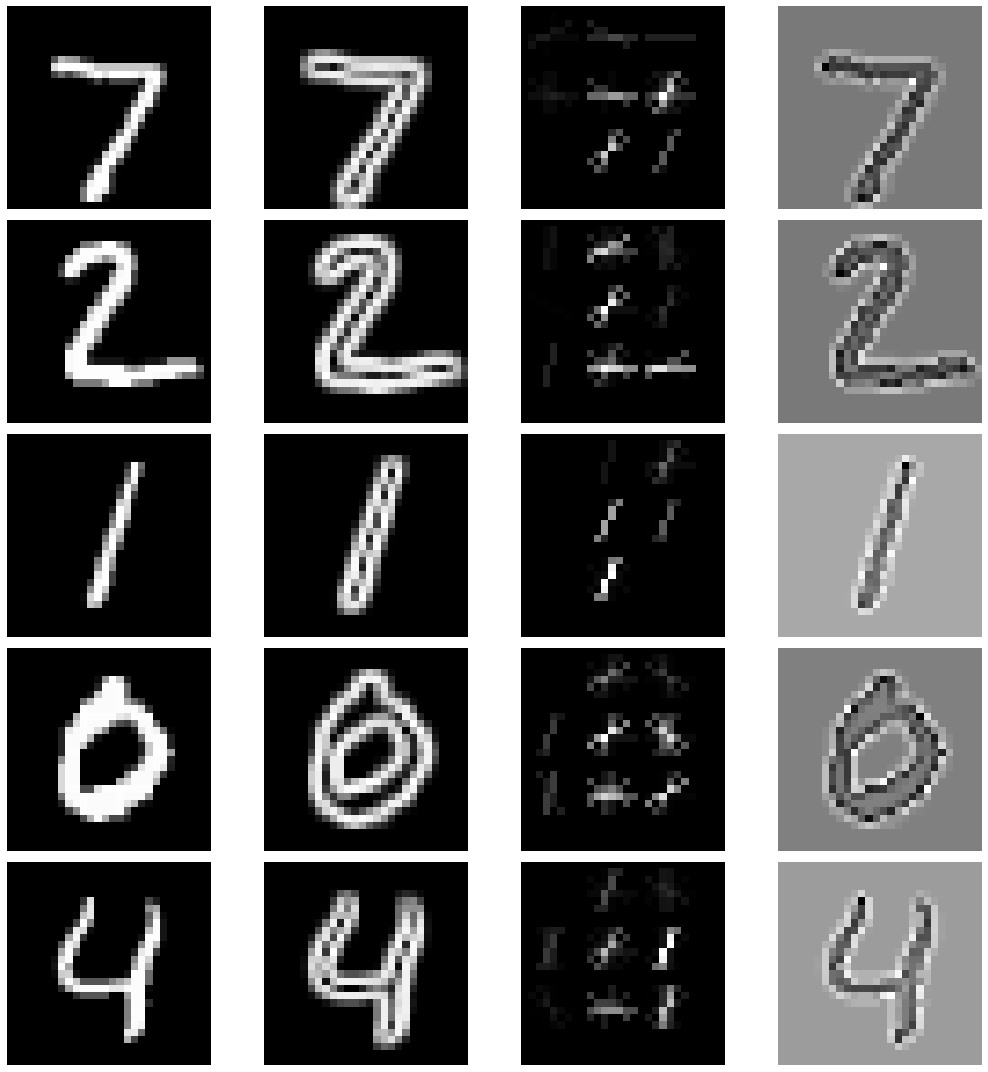

In [15]:
groups = 5
images_per_group = 4
image_height = 28
image_width = 28


# Create subplots
fig, axes = plt.subplots(groups, images_per_group, figsize=(15, 15))

# Plot each image in the corresponding subplot
for g in range(groups):
    axes[g, 0].imshow(x_test[g], cmap='gray')
    axes[g, 0].axis('off')

    axes[g, 1].imshow(sobel_x_test_final[g], cmap='gray')
    axes[g, 1].axis('off')

    axes[g, 2].imshow(HOG_test[g], cmap='gray')
    axes[g, 2].axis('off')

    axes[g, 3].imshow(Laplacian_test[g], cmap='gray')
    axes[g, 3].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Phase 2

Average Image Shape: (28, 28)


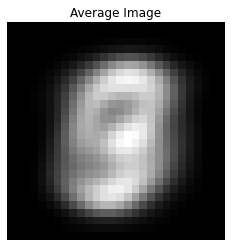

In [16]:

average_image = np.mean(x_combined, axis=0)

# average_image will have the shape (28, 28)
print("Average Image Shape:", average_image.shape)



plt.imshow(average_image, cmap='gray')
plt.title('Average Image')
plt.axis('off')  # Hide axis
plt.show()

5 0 4 1


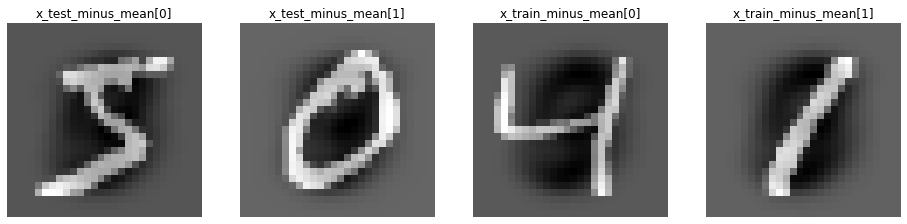

In [23]:
x_test_minus_mean = x_test - average_image
x_train_minus_mean = x_train - average_image
centered_images = x_combined - average_image


plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(centered_images[0], cmap='gray')
plt.title('x_test_minus_mean[0]')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(centered_images[1], cmap='gray')
plt.title('x_test_minus_mean[1]')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(centered_images[2], cmap='gray')
plt.title('x_train_minus_mean[0]')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(centered_images[3], cmap='gray')
plt.title('x_train_minus_mean[1]')
plt.axis('off')

print(f"{y_combined[0]} {y_combined[1]} {y_combined[2]} {y_combined[3]}")
plt.show()

(70000, 784)


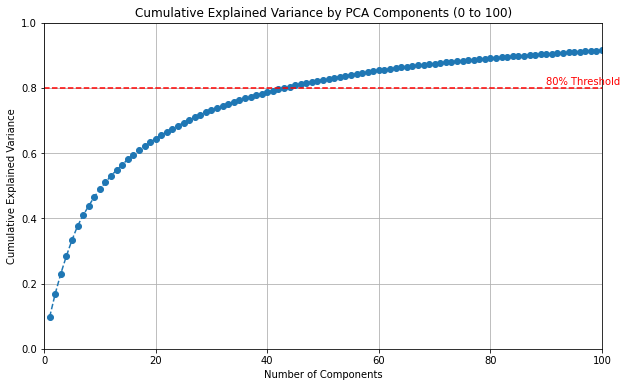

The best number of components for at least 80% explained variance is: 43


In [18]:
reshaped_images = centered_images.reshape(centered_images.shape[0], -1)
print(reshaped_images.shape)

# Perform PCA with a maximum of 100 components
max_components = 100
pca = PCA(n_components=max_components)
pca.fit(reshaped_images)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotting the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components (0 to 100)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.xlim(0, max_components)
plt.ylim(0, 1)
plt.axhline(y=0.80, color='r', linestyle='--')  # Threshold at 80%
plt.text(max_components - 10, 0.81, '80% Threshold', color='red')
plt.show()

# Find the best number of components for at least 80% explained variance
best_n_components = np.argmax(cumulative_variance >= 0.80) + 1  # +1 because index starts at 0

print(f"The best number of components for at least 80% explained variance is: {best_n_components}")

In [19]:
reshaped_images = centered_images.reshape(centered_images.shape[0], -1)
# print(reshaped_images.shape)

# Standardize the data
# scaler = StandardScaler()
# scaled_images = scaler.fit_transform(reshaped_images)

# Perform PCA with n_components = 43
n_components = best_n_components
pca = PCA(n_components=n_components)
pca.fit(reshaped_images)

# Transform the data to the new PCA space
pca_transformed = pca.transform(reshaped_images)
x_pca_centered_train ,x_pca_centered_test, y_pca_centered_train, y_pca_centered_test = train_test_split(pca_transformed, y_combined, test_size=0.2, random_state=42)

# # Print explained variance for each component
# explained_variance = pca.explained_variance_ratio_
# print(f"Explained Variance Ratios for {n_components} components:")
# print(explained_variance)

# Cumulative explained variance
# cumulative_variance = np.cumsum(explained_variance)

# # Plotting the explained variance for each component
# plt.figure(figsize=(10, 6))
# plt.bar(range(1, n_components + 1), explained_variance, alpha=0.7, color='b', label='Individual Explained Variance')
# plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='--', color='r', label='Cumulative Explained Variance')
# plt.title('Explained Variance by PCA Components (n_components = 43)')
# plt.xlabel('Number of Components')
# plt.ylabel('Explained Variance Ratio')
# plt.xticks(range(1, n_components + 1))
# plt.legend()
# plt.grid()
# plt.show()

# # Optionally visualize the first two principal components if desired
# plt.figure(figsize=(8, 6))
# plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], alpha=0.5)
# plt.title('PCA: First Two Principal Components')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.grid()
# plt.show()
print(x_pca_centered_train.shape)

(56000, 43)


In [20]:
HOG_sobel_total = np.concatenate((HOG_sobel_train, HOG_sobel_test))
print(HOG_sobel_total.shape)

(70000, 928)


In [29]:
average_image2 = np.mean(HOG_sobel_total, axis=0)
# print(f"mean = {average_image2}")

centered_HOG_Sobel_images = HOG_sobel_total - average_image2

(70000, 928)


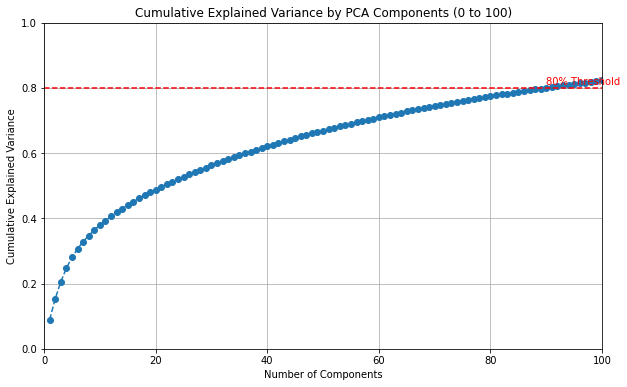

The best number of components for at least 80% explained variance is: 90


In [30]:
reshaped_images = centered_HOG_Sobel_images
print(reshaped_images.shape)

# Perform PCA with a maximum of 100 components
max_components = 100
pca2 = PCA(n_components=max_components)
pca2.fit(reshaped_images)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca2.explained_variance_ratio_)

# Plotting the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components (0 to 100)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.xlim(0, max_components)
plt.ylim(0, 1)
plt.axhline(y=0.80, color='r', linestyle='--')  # Threshold at 80%
plt.text(max_components - 10, 0.81, '80% Threshold', color='red')
plt.show()

# Find the best number of components for at least 80% explained variance
best_n_components2 = np.argmax(cumulative_variance >= 0.80) + 1  # +1 because index starts at 0

print(f"The best number of components for at least 80% explained variance is: {best_n_components2}")

In [31]:
reshaped_images = centered_HOG_Sobel_images
# print(reshaped_images.shape)

# Standardize the data
# scaler = StandardScaler()
# scaled_images = scaler.fit_transform(reshaped_images)

# Perform PCA with n_components = 43
n_components = best_n_components2
pca2 = PCA(n_components=n_components)
pca2.fit(reshaped_images)

# Transform the data to the new PCA space
pca_transformed = pca2.transform(reshaped_images)
x_pca_HOG_Sobel_train ,x_pca_HOG_Sobel_test, y_pca_HOG_Sobel_train, y_pca_HOG_Sobel_test = train_test_split(pca_transformed, y_combined, test_size=0.2, random_state=42)

# # Print explained variance for each component
# explained_variance = pca.explained_variance_ratio_
# print(f"Explained Variance Ratios for {n_components} components:")
# print(explained_variance)

# Cumulative explained variance
# cumulative_variance = np.cumsum(explained_variance)

# # Plotting the explained variance for each component
# plt.figure(figsize=(10, 6))
# plt.bar(range(1, n_components + 1), explained_variance, alpha=0.7, color='b', label='Individual Explained Variance')
# plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='--', color='r', label='Cumulative Explained Variance')
# plt.title('Explained Variance by PCA Components (n_components = 43)')
# plt.xlabel('Number of Components')
# plt.ylabel('Explained Variance Ratio')
# plt.xticks(range(1, n_components + 1))
# plt.legend()
# plt.grid()
# plt.show()

# # Optionally visualize the first two principal components if desired
# plt.figure(figsize=(8, 6))
# plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], alpha=0.5)
# plt.title('PCA: First Two Principal Components')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.grid()
# plt.show()
print(x_pca_HOG_Sobel_train.shape)


(56000, 90)


Phase 3

In [ ]:
print(x_pca_centered_train.shape)
x_pca_HOG_Sobel_test

(56000, 43)


In [33]:
# Define the Decision Tree model
model = DecisionTreeClassifier(random_state=42)

# Create a hyperparameter grid
# param_grid = {
#     'max_depth': [3, 5, 8, 10, 15, 20],
#     'min_samples_split': [2, 5, 8, 10, 15],
#     'min_samples_leaf': [2, 5, 10, 15],
#     'criterion': ['gini', 'entropy']
# }
param_grid = {
    'max_depth': [15],
    'min_samples_split': [8],
    'min_samples_leaf': [2],
    'criterion': ['gini', 'entropy']
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model on the training data
grid_search.fit(x_pca_centered_train, y_pca_centered_train)

# Print the best hyperparameters and accuracy score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy (CV):", grid_search.best_score_)

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(x_pca_centered_test, y_pca_centered_test)
print("Test Accuracy:", test_accuracy)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 8}
Best Accuracy (CV): 0.8467500000000001
Test Accuracy: 0.8562142857142857


In [34]:
with open('best_model_centered.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [35]:
# Load the model from the file
with open('best_model_centered.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# You can now use loaded_model to make predictions
predictions = loaded_model.predict(x_pca_centered_test)
print(predictions)


[8 7 8 ... 2 7 1]


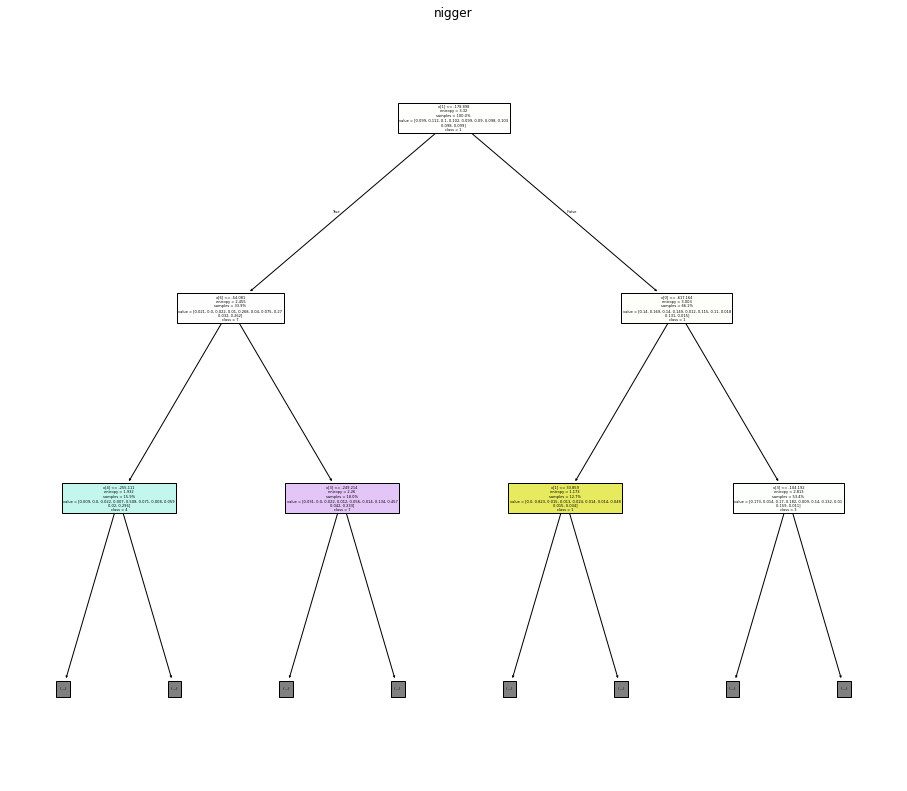

In [36]:
def plot_tree_model(model, title, max_depth=None):
    plt.figure(figsize=(16, 14))
    plot_tree(
        model, 
        filled=True, 
        max_depth=max_depth,  # Option to restrict the visible depth
        feature_names=None, 
        class_names=[str(i) for i in range(10)], 
        proportion=True
    )

    plt.title(title)
    plt.show()

plot_tree_model(loaded_model, 'nigger', 2)

In [69]:
print(x_train.shape)
print(x_test.shape)
# Assuming x_train is your original array with shape (60000, 28, 28)
x_train_reshaped = x_train.reshape(60000, 28 * 28)
x_test_reshaped = x_test.reshape(10000, 28 * 28)

# Alternatively, you can use:
# x_train_reshaped = x_train.reshape(60000, -1)  # -1 automatically calculates the size of the second dimension

print(x_train_reshaped.shape) 
print(x_test_reshaped.shape)


(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


In [ ]:
# Define the Decision Tree model
model2 = DecisionTreeClassifier(random_state=42)

# Create a hyperparameter grid
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [ 5, 8, 10],
    'min_samples_leaf': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search2 = GridSearchCV(estimator=model2, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model on the training data
grid_search2.fit(x_train_reshaped, y_train)

# Print the best hyperparameters and accuracy score
print("Best Hyperparameters:", grid_search2.best_params_)
print("Best Accuracy (CV):", grid_search2.best_score_)

# Evaluate the best model on the test data
best_model2 = grid_search2.best_estimator_
test_accuracy = best_model2.score(x_test_reshaped, y_test)
print("Test Accuracy:", test_accuracy)

In [ ]:
with open('best_model_raw_data.pkl', 'wb') as file:
    pickle.dump(best_model2, file)

In [ ]:
# Load the model from the file
with open('best_model_raw_data.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# You can now use loaded_model to make predictions
predictions = loaded_model.predict(x_pca_centered_test)
print(predictions)


In [ ]:
# Define the Decision Tree model
model3 = DecisionTreeClassifier(random_state=42)

# Create a hyperparameter grid
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [ 5, 8, 10],
    'min_samples_leaf': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search3 = GridSearchCV(estimator=model3, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model on the training data
grid_search3.fit(x_pca_HOG_Sobel_train, y_pca_HOG_Sobel_train)

# Print the best hyperparameters and accuracy score
print("Best Hyperparameters:", grid_search3.best_params_)
print("Best Accuracy (CV):", grid_search3.best_score_)

# Evaluate the best model on the test data
best_model3 = grid_search3.best_estimator_
test_accuracy = best_model3.score(x_pca_HOG_Sobel_test, y_pca_HOG_Sobel_test)
print("Test Accuracy:", test_accuracy)

In [ ]:
with open('best_model_pca_HOG_Sobel.pkl', 'wb') as file:
    pickle.dump(best_model3, file)

In [ ]:
# Load the model from the file
with open('best_model_pca_HOG_Sobel.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# You can now use loaded_model to make predictions
predictions = loaded_model.predict(x_pca_centered_test)
print(predictions)


In [72]:
print(sobel_x_train_final.shape)
print(sobel_x_test_final.shape)
# Assuming x_train is your original array with shape (60000, 28, 28)
sobel_x_train_reshaped = sobel_x_train_final.reshape(60000, 28 * 28)
sobel_x_test_reshaped = sobel_x_test_final.reshape(10000, 28 * 28)

# Alternatively, you can use:
# x_train_reshaped = x_train.reshape(60000, -1)  # -1 automatically calculates the size of the second dimension

print(sobel_x_train_reshaped.shape) 
print(sobel_x_test_reshaped.shape)


(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


In [ ]:
# Define the Decision Tree model
model4 = DecisionTreeClassifier(random_state=42)

# Create a hyperparameter grid
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [ 5, 8, 10],
    'min_samples_leaf': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search4 = GridSearchCV(estimator=model4, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model on the training data
grid_search4.fit(x_pca_HOG_Sobel_train, y_pca_HOG_Sobel_train)

# Print the best hyperparameters and accuracy score
print("Best Hyperparameters:", grid_search4.best_params_)
print("Best Accuracy (CV):", grid_search4.best_score_)

# Evaluate the best model on the test data
best_model4 = grid_search4.best_estimator_
test_accuracy = best_model4.score(x_pca_HOG_Sobel_test, y_pca_HOG_Sobel_test)
print("Test Accuracy:", test_accuracy)

In [ ]:
with open('best_model_Sobel.pkl', 'wb') as file:
    pickle.dump(best_model4, file)

In [ ]:
# Load the model from the file
with open('best_model_Sobel.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# You can now use loaded_model to make predictions
predictions = loaded_model.predict(x_pca_centered_test)
print(predictions)


In [ ]:
# Define the SVM model
modelSVC = SVC(random_state=42)

# Create a hyperparameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']  # 'scale' is the default in newer versions of scikit-learn
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=modelSVC, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model on the training data
grid_search.fit(x_train_reshaped, y_train)

# Print the best hyperparameters and accuracy score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy (CV):", grid_search.best_score_)

# Evaluate the best model on the test data
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(x_test_reshaped, y_test)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred = best_model.predict(x_test_reshaped)

# Print classification report and confusion matrix
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Optional: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix(y_test, y_pred), interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
# plt.xticks(np.arange(len(iris.target_names)), iris.target_names, rotation=45)
# plt.yticks(np.arange(len(iris.target_names)), iris.target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


IndexError: list index out of range

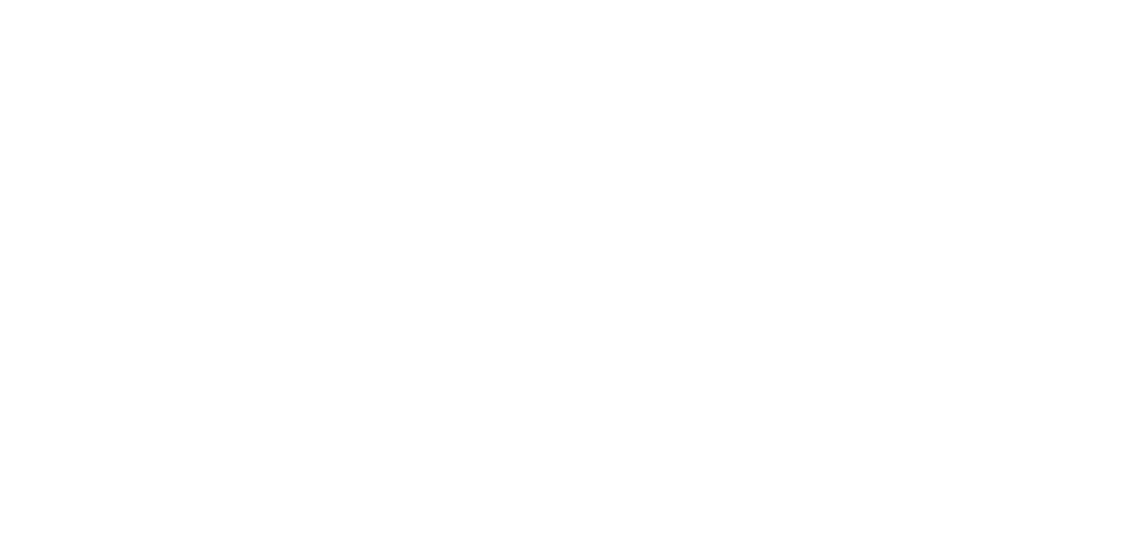

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.tree import plot_tree
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import GridSearchCV

# # Assuming you have already defined and fitted your model as shown in your previous code
# # model = DecisionTreeClassifier(random_state=42)
# # grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
# # grid_search.fit(x_pca_centered_train, y_pca_centered_train)
# # best_model = grid_search.best_estimator_

# # Now, plot the best decision tree model
# plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
# plot_tree(best_model, 
#           filled=True, 
#           feature_names=None,  # Replace with your actual feature names
#           class_names=['Class1', 'Class2'],  # Replace with your actual class names
#           rounded=True, 
#           fontsize=14)

# plt.title("Best Decision Tree Model")
# plt.show()


(28, 28)


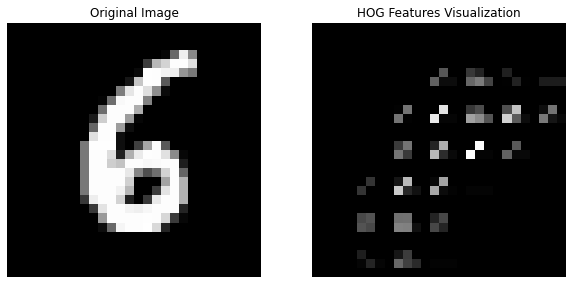

In [ ]:
# image = x_test[986]

# orientations = 9
# pixels_per_cell = (4, 4)
# cells_per_block = (2, 2)

# hog_features, hog_image = feature.hog(image, orientations=orientations,
#                                        pixels_per_cell=pixels_per_cell,
#                                        cells_per_block=cells_per_block,
#                                        visualize=True, feature_vector=False)


# hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))


# # print(hog_features)
# print(hog_image.shape)
# # Step 4: Plotting the results
# plt.figure(figsize=(10, 5))

# plt.subplot(1, 2, 1)
# plt.title('Original Image')
# plt.imshow(image, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.title('HOG Features Visualization')
# plt.imshow(HOG_train[59999], cmap='gray')
# plt.axis('off')

# plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# from skimage.feature import hog
# from skimage import data, exposure


# image = data.astronaut()

# fd, hog_image = hog(
#     image,
#     orientations=8,
#     pixels_per_cell=(16, 16),
#     cells_per_block=(1, 1),
#     visualize=True,
#     channel_axis=-1,
# )

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

# ax1.axis('off')
# ax1.imshow(image, cmap=plt.cm.gray)
# ax1.set_title('Input image')

# # Rescale histogram for better display
# hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# ax2.axis('off')
# ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
# ax2.set_title('Histogram of Oriented Gradients')
# plt.show()
# print(fd.min())

ModuleNotFoundError: The requested file is part of the scikit-image distribution, but requires the installation of an optional dependency, pooch. To install pooch, use your preferred python package manager. Follow installation instruction found at https://scikit-image.org/docs/stable/user_guide/install.html

In [ ]:
# print(padded_x_test.shape)
# print(padded_x_train[59999])
# print(type(sobel_x_test_final))

<class 'numpy.ndarray'>


6


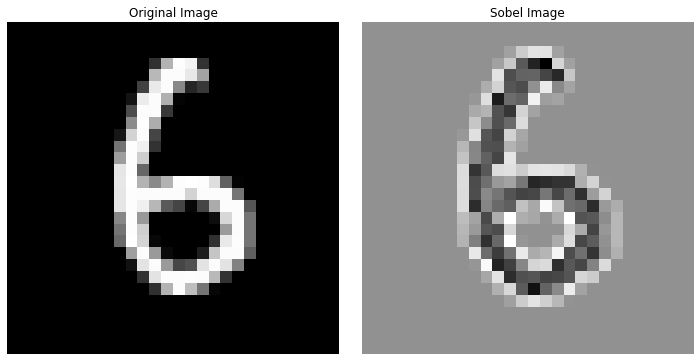

In [ ]:

# plt.figure(figsize=(10, 5))

# # First subplot for the original image
# plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
# plt.title('Original Image')
# plt.imshow(x_test[21], cmap='gray')
# plt.axis('off')  # Hide axis ticks

# # Second subplot for the Sobel image (or scaled result)
# plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
# plt.title('Sobel Image')
# plt.imshow(Laplacian_test[21], cmap='gray')
# plt.axis('off')  # Hide axis ticks
# print(y_test[21])
# # Show the plots
# plt.tight_layout()  # Adjust layout to prevent overlap
# plt.show()